<a href="https://colab.research.google.com/github/najouaelfethi/bigdataproject/blob/main/Mapreduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/AEP_hourly.csv')
data.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [ ]:
print('Nombre de lignes:', len(data))
print('Nombre de colonnes:', len(data.columns))
print('Size du dataset:', data.ndim)

Nombre de lignes: 121273
Nombre de colonnes: 2
Size du dataset: 2


split datetime into date and time

In [ ]:
data['Dates'] = pd.to_datetime(data['Datetime']).dt.date
data['Time'] = pd.to_datetime(data['Datetime']).dt.time
data['House_id'] = data.index
df = data.reindex(['House_id','Dates','Time','AEP_MW'],axis=1)
df.head()

,House_id,Dates,Time,AEP_MW
0,0,2004-12-31,01:00:00,13478.0
1,1,2004-12-31,02:00:00,12865.0
2,2,2004-12-31,03:00:00,12577.0
3,3,2004-12-31,04:00:00,12517.0
4,4,2004-12-31,05:00:00,12670.0


# **Mapreduce Phase**

Cas 1: Calcule de la consommation d'energie moyenne par mois: pour voir saisons ou la consommation est enorme

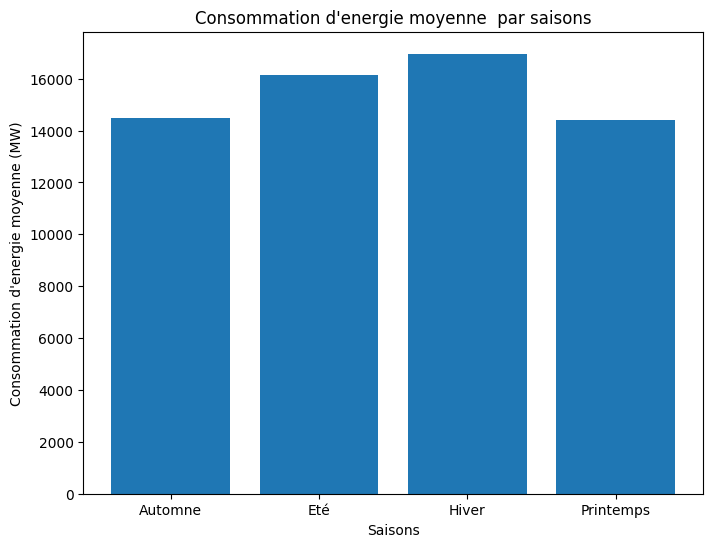

In [ ]:
#AJout d'une colonne des mois
df['Dates'] = pd.to_datetime(df['Dates'])
df['Month'] = df['Dates'].dt.month

#definir saisons
def seasons(month):
  if month in [12,1,2]:
    return 'Hiver'
  elif month in [3,4,5]:
    return 'Printemps'
  elif month in [6,7,8]:
    return 'Eté'
  elif month in [9,10,11]:
    return 'Automne'

df['Season'] = df['Month'].apply(seasons)

#Map phase: energie total consommer et nombre de lignes pour chaque saison
grouping_by_seasons = df.groupby('Season').AEP_MW.agg(['sum','count'])

#Reduce phase: Moyenne de la consommation d'energie par saison
grouping_by_seasons['Consommation moyenne'] = grouping_by_seasons['sum'] / grouping_by_seasons['count']

#Ordre descendant de la consommation moyenne
sorting = grouping_by_seasons.sort_values('Consommation moyenne', ascending=False)

#Plotting resultats
plt.figure(figsize=(8,6))
plt.bar(grouping_by_seasons.index, grouping_by_seasons['Consommation moyenne'])
plt.title("Consommation d'energie moyenne  par saisons")
plt.xlabel('Saisons')
plt.ylabel("Consommation d'energie moyenne (MW)")
plt.show()

**Interpretation**: <br>
* Dans la saison d'hiver la consommation d'energie est la plus eleve cela peut s'expliquer pas la forte demande d'energie lie au chauffage dans les regions froides
* La saison d'ete vient apres, la consommation est eleve peut etre lie a l'utilisation des climatiseurs dans les regions chaudes
* La consommation d'energie est plus faible dans l'automne et le printemps car ces saisons ont souvent des temperatures plus moderes ce qui reduit la necessite de l'utilisation des climatiseurs et des chauffages

Cas 2: Heures de la journee ou la consommation est eleve




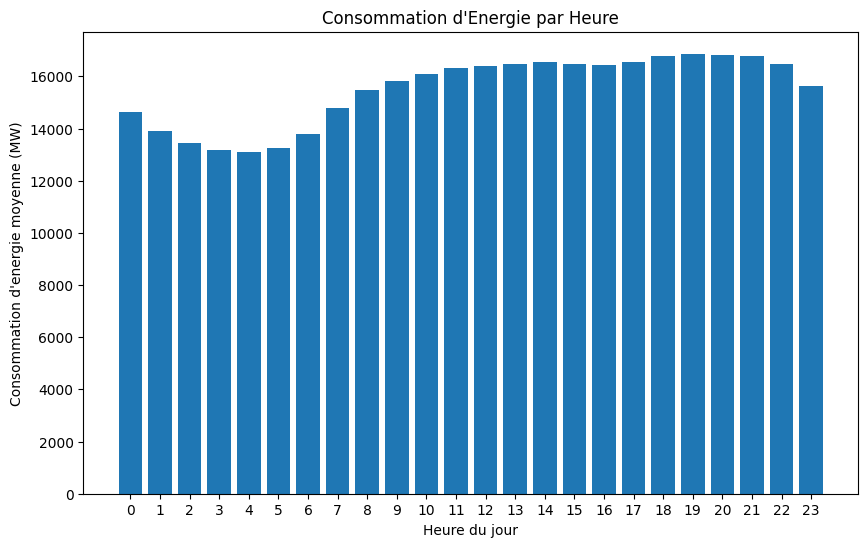

In [ ]:
#Map phase: key-value pairs of (heure, energie consomme)
mapped = [(heure.hour,consommation) for heure,consommation in zip(df['Time'],df['AEP_MW'])]

#dictionnary to group consommations d'energie par heure => exemple: {1 am: [c11,c12,c13...], 2am: [c21,22,c23,...]}
reduced = defaultdict(list)
for heure,consommation in mapped:
  reduced[heure].append(consommation)

#Moyenne de la consommation d'energie par heure
hourly_mean = {heure: sum(values)/len(values) for heure, values in reduced.items()}

#ordonner des consommation d'energie par heure
hourly_consommation = dict(sorted(hourly_mean.items()))

#Plotting resultats
plt.figure(figsize=(10,6))
plt.bar(list(hourly_consommation.keys()), list(hourly_consommation.values()))
plt.xticks(range(24))
plt.title("Consommation d'Energie par Heure")
plt.xlabel('Heure du jour')
plt.ylabel("Consommation d'energie moyenne (MW)")
plt.show()


**Iterpretation**: <br>
La consommation d'energie est eleve a partie du 9AM jusqu'a 12PM et presque stable pendant le midi 12PM jusqu'a 15h et augmente encore une fois pendant le soir du 18h jusqu'a 21h. La consommation d'energie est faible pendant le matin tot.